In [119]:
import pandas as pd
import numpy as np
# import feather
import datetime
# import talib
# import mysql.connector
import matplotlib.pyplot as plt
from numpy.random import seed
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.metrics import accuracy_score, classification_report,confusion_matrix,roc_auc_score, roc_curve
from sklearn.preprocessing import MinMaxScaler, StandardScaler
import keras
import tensorflow as tf
from tensorflow.compat.v1 import set_random_seed
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l1
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.models import load_model
from imblearn.over_sampling import SMOTE

from py5paisa import FivePaisaClient

In [79]:
seed(1)
set_random_seed(2)
client = FivePaisaClient(email="52119099", passwd="#bhola@1996", dob="19840101")
client.login()

 12:01:53 | Logged in!!


In [7]:
scriptDf = pd.read_csv('../HistoricalData/NSECashScripts.csv')

In [76]:
symbol = 'banknifty'
end = datetime.datetime.now()
start = end - datetime.timedelta(100)

scode = int(scriptDf[scriptDf['Name']==symbol.upper()]['Scripcode'])
data = client.historical_data('N' , 'C' , scode ,'1m', start ,end)
data.set_index('Datetime' , inplace=True)
data.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-10T11:53:00,33203.80,33206.50,33199.75,33201.60,0
2021-05-10T11:54:00,33203.35,33214.25,33198.50,33204.85,0
2021-05-10T11:55:00,33205.15,33208.60,33201.90,33205.15,0
2021-05-10T11:56:00,33206.00,33206.00,33185.00,33189.10,0
2021-05-10T11:57:00,33188.40,33193.95,33177.00,33179.00,0


In [84]:
def getData(symbol,start,end):   
    try:
        scode = int(scriptDf[scriptDf['Name']==symbol.upper()]['Scripcode'])
        data = client.historical_data('N' , 'C' , scode ,'1m', start ,end)
        data.set_index('Datetime' , inplace=True)
        data.index = pd.to_datetime(data.index)
        return data
    except Exception as e:
            print("Error : " , e) 

In [109]:
def balanceData(X,y):
    sm = SMOTE(random_state=2)
    X, y = sm.fit_resample(X, y)    
    return pd.DataFrame(X),pd.Series(y)

In [52]:
end = datetime.datetime.today()
start = end - datetime.timedelta(100)
symbol = 'BANKNIFTY'
#Text formatting
boldTextStart = "\033[1m"
boldTextEnd = "\033[0;0m"

In [85]:
dataset = getData(symbol,start,end)
data = dataset.copy()
data.shape

(26326, 5)

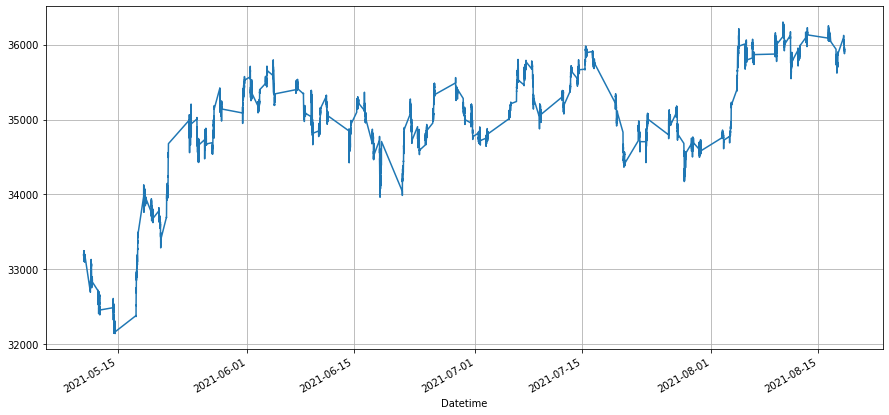

In [86]:
data['Close'].plot(figsize=(15,7))
plt.grid()
plt.show()

In [87]:
data.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-10 11:53:00,33203.80,33206.50,33199.75,33201.60,0
2021-05-10 11:54:00,33203.35,33214.25,33198.50,33204.85,0
2021-05-10 11:55:00,33205.15,33208.60,33201.90,33205.15,0
2021-05-10 11:56:00,33206.00,33206.00,33185.00,33189.10,0
2021-05-10 11:57:00,33188.40,33193.95,33177.00,33179.00,0


In [88]:
initial_balance1 = data.between_time(start_time = '09:16:00', end_time = '10:15:00', include_end = True)
initial_balance2 = data.between_time(start_time = '14:31:00', end_time = '15:30:00', include_end = True)
initial_balance = pd.concat([initial_balance1,initial_balance2],axis=0)

In [89]:
initial_balance.dropna(inplace=True)

In [90]:
initial_balance.head()

,Open,High,Low,Close,Volume
Datetime,,,,,
2021-05-11 09:16:00,32696.00,32698.50,32665.25,32696.45,0
2021-05-11 09:17:00,32697.95,32702.80,32670.20,32701.05,0
2021-05-11 09:18:00,32698.45,32728.80,32698.45,32718.45,0
2021-05-11 09:19:00,32715.20,32721.05,32694.00,32721.05,0
2021-05-11 09:20:00,32711.65,32728.90,32686.05,32728.80,0


In [92]:
eod_returns = data.between_time(start_time = '09:16:00', end_time = '15:30:00', include_end = True)

In [95]:
conversion = {'Open' : 'first', 'High' : 'max', 'Low' : 'min', 'Close' : 'last'}
data2 = eod_returns.resample('1D').agg(conversion)
data2['target'] = data2['Open']/data2['Close'].shift(1)
data2.dropna(inplace=True)

In [15]:
data2.head()

,low,open,close,high,target
date,,,,,
2018-01-02,25232.8,25387.0,25319.5,25425.5,1.004566
2018-01-03,25300.9,25433.2,25326.2,25454.9,1.004491
2018-01-04,25310.3,25356.1,25478.4,25490.3,1.001181
2018-01-05,25499.6,25510.2,25619.9,25643.3,1.001248
2018-01-09,25617.3,25737.4,25688.0,25803.8,1.002626


In [96]:
from datetime import timedelta, date

def daterange(start_date, end_date):
    for n in range(int ((end_date - start_date).days)):
        yield start_date + timedelta(n)

In [97]:
X = []
y = []
for single_date in daterange(start, end+timedelta(1)):
    if single_date.strftime("%Y-%m-%d") in data2.index:
        curr = single_date.strftime("%Y-%m-%d")
        
        Xdelta = []
        for i in range(0,initial_balance.loc[curr].shape[0]):
            
            for j in range(0,4):
                Xdelta.append(initial_balance.loc[curr].iloc[i][j])
        print(curr,' ',len(Xdelta))
        if(len(Xdelta) == 480):
            X.append(Xdelta)
            y.append(data2.loc[curr].loc['target'])
        else:
            print('Excluded - ',curr,' Length: ',len(Xdelta))

2021-05-11   480
2021-05-12   480
2021-05-18   480
2021-05-19   480
2021-05-20   480
2021-05-21   480
2021-05-25   480
2021-05-26   480
2021-05-27   480
2021-05-28   480
2021-06-01   480
2021-06-02   480
2021-06-03   480
2021-06-04   480
2021-06-08   480
2021-06-09   480
2021-06-10   480
2021-06-11   480
2021-06-15   480
2021-06-16   480
2021-06-17   480
2021-06-18   480
2021-06-22   480
2021-06-23   480
2021-06-24   480
2021-06-25   480
2021-06-29   480
2021-06-30   480
2021-07-01   480
2021-07-02   480
2021-07-06   480
2021-07-07   480
2021-07-08   480
2021-07-09   480
2021-07-13   480
2021-07-14   480
2021-07-15   480
2021-07-16   480
2021-07-20   480
2021-07-23   480
2021-07-27   480
2021-07-28   480
2021-07-29   480
2021-07-30   480
2021-08-03   480
2021-08-04   480
2021-08-05   480
2021-08-06   480
2021-08-10   480
2021-08-11   480
2021-08-12   480
2021-08-13   480
2021-08-17   480
2021-08-18   240
Excluded -  2021-08-18  Length:  240


In [98]:
print('Dimension of X:',len(X),'x',len(X[0]))
print('Dimension of y:',len(y))

Dimension of X: 53 x 480
Dimension of y: 53


In [99]:
cols = []
for i in range(0,120):
    for j in range(0,4):
        cols.append('f'+str(i)+str(j))
len(cols)

480

In [100]:
y = pd.Series(y)
X = pd.DataFrame(np.reshape(X,(y.shape[0],len(cols))), columns=cols)

In [101]:
target = pd.DataFrame()
target['Close'] = y

In [102]:
target.shape

(53, 1)

In [103]:
target['dir'] = 0
target['dir'] = np.where(target['Close'] > 1, 1, 0)

In [104]:
y = pd.Series(target['dir'])
y.shape

(53,)

In [105]:
X_y = pd.concat([X, y], axis=1)

In [106]:
X_y.dropna(inplace=True)
X = X_y.iloc[:,:-1]
y = X_y.iloc[:,-1]

In [107]:
print(sum(y == 0))
print(sum(y == 1))

19
34


In [110]:
X_balanced,y_balanced = balanceData(X,y)
print(sum(y_balanced == 0))
print(sum(y_balanced == 1))

34
34


In [111]:
print('Dimension of X:',X.shape)
print('Dimension of y:',len(y))

Dimension of X: (53, 480)
Dimension of y: 53


In [112]:
X_train, X_test, y_train, y_test = train_test_split(X_balanced,y_balanced, test_size=0.2, shuffle=True)

In [113]:
print(X_train.shape)
print(X_test.shape)

(54, 480)
(14, 480)


In [114]:
print(sum(y_train == 0))
print(sum(y_train == 1))
print(sum(y_test == 0))
print(sum(y_test == 1))

26
28
8
6


In [115]:
# Normalizing data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [121]:
unit = 1024
optimizer = SGD(lr=0.001, momentum=0.0, nesterov=True)
kernel_init = 'he_uniform'
activation = 'relu'   
checkpoint = tf.keras.callbacks.ModelCheckpoint('./models/bestmodel.h5', verbose=1, monitor='val_acc',save_best_only=True, mode='auto')
stoppoint = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='auto', verbose=0, patience=200)
classifier = Sequential()
classifier.add(Dense(units = 512, kernel_initializer = kernel_init, activation = activation,input_dim = X_train_scaled.shape[1]))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = unit//2, kernel_initializer = kernel_init, activation = activation))
classifier.add(Dense(units = 1, kernel_initializer = kernel_init, activation = 'sigmoid'))
classifier.compile(optimizer = optimizer, loss = 'binary_crossentropy', metrics = ['accuracy'])
classifier.fit(X_train_scaled, y_train, batch_size = 50, epochs = 1000, 
               validation_split = 0.3 , callbacks=[checkpoint, stoppoint],verbose=1)

/home/rahul/.local/lib/python3.8/site-packages/tensorflow/python/keras/optimizer_v2/optimizer_v2.py:374: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  warnings.warn(


Epoch 1/1000
1/1 [==============================] - 1s 523ms/step - loss: 0.8188 - accuracy: 0.5405 - val_loss: 0.9325 - val_accuracy: 0.3529
Epoch 2/1000
1/1 [==============================] - 0s 69ms/step - loss: 0.7478 - accuracy: 0.5405 - val_loss: 0.8331 - val_accuracy: 0.3529
Epoch 3/1000
1/1 [==============================] - 0s 85ms/step - loss: 0.7087 - accuracy: 0.5405 - val_loss: 0.7765 - val_accuracy: 0.3529
Epoch 4/1000
1/1 [==============================] - 0s 83ms/step - loss: 0.6892 - accuracy: 0.5405 - val_loss: 0.7430 - val_accuracy: 0.3529
Epoch 5/1000
1/1 [==============================] - 0s 84ms/step - loss: 0.6786 - accuracy: 0.5676 - val_loss: 0.7209 - val_accuracy: 0.3529
Epoch 6/1000
1/1 [==============================] - 0s 80ms/step - loss: 0.6715 - accuracy: 0.5676 - val_loss: 0.7060 - val_accuracy: 0.3529
Epoch 7/1000
1/1 [==============================] - 0s 77ms/step - loss: 0.6660 - accuracy: 0.5946 - val_loss: 0.6954 - val_accuracy: 0.4118
Epoch 8/1000

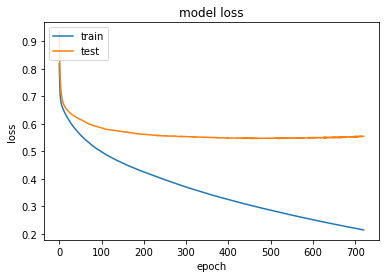

In [122]:
# summarize history for loss
plt.plot(classifier.history.history['loss'])
plt.plot(classifier.history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [124]:
classifier.save('./models/bestmodel')

2021-08-18 12:45:44.473958: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: ./models/bestmodel/assets


In [125]:
#model = load_model('./Saved Models/model360-2509-653.h5')
# model = load_model('bestmodel.h5')
# model.summary()
model = classifier

In [126]:
#Accuracy of test set
y_pred = model.predict(X_test_scaled)
y_pred = (y_pred > 0.5)
print(boldTextStart,'Accuracy:',boldTextEnd)
accuracy_model = accuracy_score(y_test, y_pred, normalize=True)*100
print(accuracy_model,' %')
print(boldTextStart,'Confusion Matrix:',boldTextEnd)
print(confusion_matrix(y_test,y_pred))
print(boldTextStart,'Classification Report:',boldTextEnd)
print(classification_report(y_test,y_pred))
auc = roc_auc_score(y_test,y_pred)
print(boldTextStart,'AUC Score: ',boldTextEnd, auc)

 Accuracy: 
50.0  %
 Confusion Matrix: 
[[5 3]
 [4 2]]
 Classification Report: 
              precision    recall  f1-score   support

           0       0.56      0.62      0.59         8
           1       0.40      0.33      0.36         6

    accuracy                           0.50        14
   macro avg       0.48      0.48      0.48        14
weighted avg       0.49      0.50      0.49        14

 AUC Score:   0.47916666666666663
